# **hideNet:** Generative Compression Model

#### Import Libraries

In [1]:
import os
import random

import cv2
import sklearn
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

IMG_PATH = 'image.jpg'

I_CHANNELS = 1
CHANNELS = 16

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Notebook running on `{DEVICE}` device")

EPOCHS = 5
IMG_SIZE = 224
BATCH_SIZE = 16
LEARNING_RATE = 1e-3

Notebook running on `mps` device


#### Utillity Functions

In [2]:
def show_image(img, title=""):
    if img.ndim == 3 or img.ndim == 2:
        plt.imshow(img, cmap="gray")
        plt.title(title)
        plt.axis("off")
        plt.show()
    else:
        ValueError("Input tensor should have 3 (C, H, W) or 2 (H, W) dimensions.")

def show_images(image1, image2, title1="Image 1", title2="Image 2"):    
    plt.figure(figsize=(10, 2))

    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray' if image1.ndim == 2 else None)
    plt.title(title1)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray' if image2.ndim == 2 else None)
    plt.title(title2)
    plt.axis("off")

    plt.show()

def bw_monotonic(img):
    if img.ndim == 4 or img.ndim == 3:
        return torch.mean(img, dim=-3, keepdim=True)
    else:
        raise ValueError("Input tensor should have 3 (C, H, W) or 4 (B, C, H, W) dimensions.")

#### Sample Image

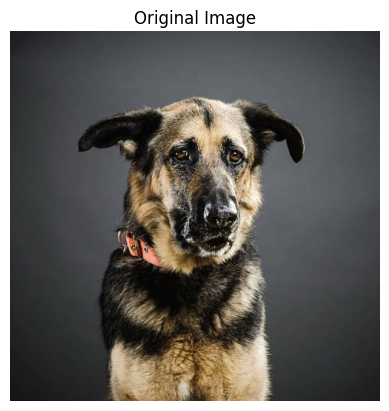

In [3]:
# RGB Image
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

show_image(img, "Original Image")

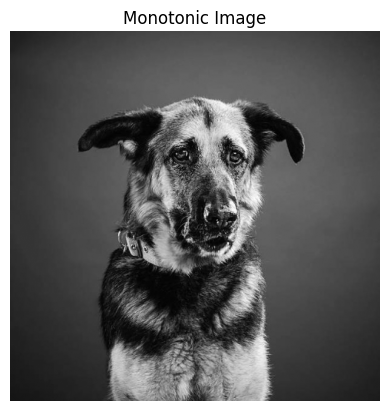

In [4]:
# BW Image
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show_image(img, "Monotonic Image")

#### Sample Batch Dimensions

In [5]:
img = np.expand_dims(img, axis=(0, 1))
img.shape

(1, 1, 500, 500)

#### Image Split

In [6]:
def split_image(image: np.ndarray):
    e_img, o_img = None, None
    if image.ndim == 4:
        e_img = image[:, :, 0::2, 1::2]
        o_img = image[:, :, 1::2, 0::2]
    elif image.ndim == 3:
        e_img = image[:, 0::2, 1::2]
        o_img = image[:, 1::2, 0::2]
    elif image.ndim == 2:
        e_img = image[0::2, 1::2]
        o_img = image[1::2, 0::2]
    else:
        raise ValueError("Unsupported image dimensions.")
    
    return e_img, o_img

e_img, o_img = split_image(img)

In [7]:
def merge_images(e_img, o_img):
    H, W = e_img.shape[-2], e_img.shape[-1] 

    if isinstance(e_img, torch.Tensor):
        e_img = e_img.detach().cpu().to(torch.float32).numpy()
    if isinstance(o_img, torch.Tensor):
        o_img = o_img.detach().cpu().to(torch.float32).numpy()
    
    if e_img.ndim == 4:
        merged_img = np.zeros((e_img.shape[0], e_img.shape[1], 2 * H, 2 * W))
        merged_img[:, :, 0::2, 1::2] = e_img
        merged_img[:, :, 1::2, 0::2] = o_img
    elif e_img.ndim == 3:
        merged_img = np.zeros((e_img.shape[0], 2 * H, 2 * W))
        merged_img[:, 0::2, 1::2] = e_img
        merged_img[:, 1::2, 0::2] = o_img
    elif e_img.ndim == 2:
        merged_img = np.zeros((2 * H, 2 * W))
        merged_img[0::2, 1::2] = e_img
        merged_img[1::2, 0::2] = o_img
    else:
        raise ValueError("Unsupported image dimensions.")

    return merged_img

img shape (HxW): (1, 1, 500, 500)
even img shape:	 (1, 1, 250, 250)


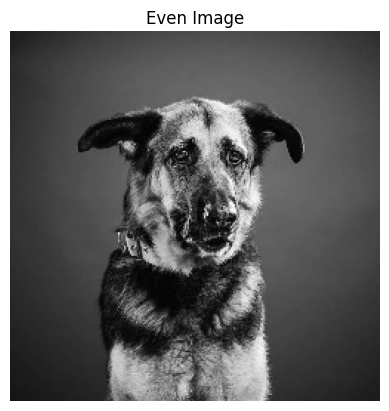

In [8]:
print("img shape (HxW):", img.shape)
print("even img shape:\t", e_img.shape)
show_image(e_img[0][0], "Even Image")

img shape (HxW): (1, 1, 500, 500)
odd img shape:	 (1, 1, 250, 250)


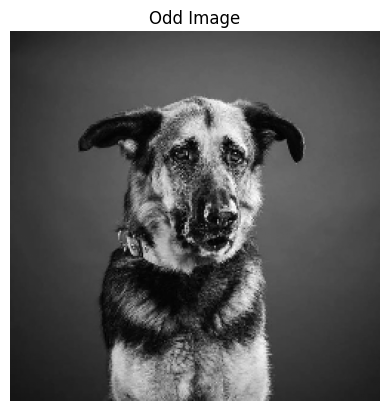

In [9]:
print("img shape (HxW):", img.shape)
print("odd img shape:\t", o_img.shape)
show_image(o_img[0][0], "Odd Image")

#### Image Merge

merged img shape (2Hx2W): (1, 1, 500, 500)


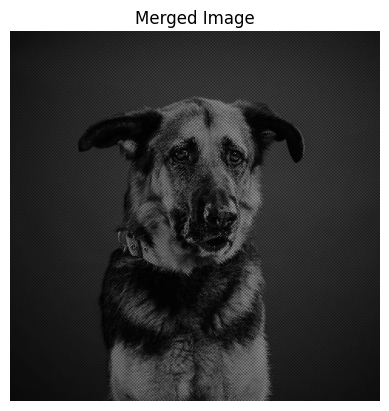

In [10]:
image_m = merge_images(e_img=e_img, o_img=o_img)
print("merged img shape (2Hx2W):", image_m.shape)
show_image(image_m[0][0], "Merged Image")

#### Neural Networks

In [11]:
class CNN(torch.nn.Module):
    def __init__(self, i_channels=I_CHANNELS, channels=CHANNELS):
        super().__init__()

        self.channels = channels
        layers = [torch.nn.Conv2d(i_channels, channels, 3, 1, 1)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channels, channels, 3, 1, 1))
        self.conv1_1 = torch.nn.Sequential(*layers)

        layers = [torch.nn.Conv2d(i_channels, channels, 5, 1, 2)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channels, channels, 3, 1, 1))
        self.conv1_2 = torch.nn.Sequential(*layers)

        layers = [torch.nn.Conv2d(i_channels, channels, 7, 1, 3)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channels, channels, 3, 1, 1))
        self.conv1_3 = torch.nn.Sequential(*layers)

        layers = [torch.nn.Conv2d(channels, channels, 3, 1, 1)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channels, channels, 3, 1, 1))
        self.conv2 = torch.nn.Sequential(*layers)

        layers = [torch.nn.Conv2d(channels, channels, 3, 1, 1)]
        layers.append(torch.nn.LeakyReLU(inplace=True))
        layers.append(torch.nn.Conv2d(channels, i_channels, 3, 1, 1))
        self.conv3 = torch.nn.Sequential(*layers)

    def forward(self, images, images_=None):
        out1_1 = self.conv1_1(images)
        out1_2 = self.conv1_2(images)
        out1_3 = self.conv1_3(images)
        out2 = self.conv2(out1_1 + out1_2 + out1_3)

        out_ = self.conv3(out1_1 + out1_2 + out1_3 + out2)

        loss = None
        if images_ is not None:
            loss = torch.nn.functional.mse_loss(out_, images_)

        return out_, loss

model = CNN()
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Number of parameters: 15,441


In [12]:
e_img = torch.tensor(e_img, dtype=torch.float32)
o_img = torch.tensor(o_img, dtype=torch.float32)

In [13]:
img_, loss = model(e_img, o_img)
print("Output shape:", img_.shape)
print("Loss:", loss)

Output shape: torch.Size([1, 1, 250, 250])
Loss: tensor(6765.2607, grad_fn=<MseLossBackward0>)


In [14]:
img_, loss = model(o_img, e_img)
print("Output shape:", img_.shape)
print("Loss:", loss)

Output shape: torch.Size([1, 1, 250, 250])
Loss: tensor(6784.9829, grad_fn=<MseLossBackward0>)


#### Dataset Training

In [15]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.CenterCrop(IMG_SIZE),
    torchvision.transforms.ToTensor(),
])

In [16]:
dataset_train = torchvision.datasets.Flowers102(root='./data/', split='train', download=True, transform=transform)
dataset_val = torchvision.datasets.Flowers102(root='./data/', split='val', download=True, transform=transform)
dataset_train_val = torch.utils.data.ConcatDataset([dataset_train, dataset_val])

dataset_test = torchvision.datasets.Flowers102(root='./data/', split='test', download=True, transform=transform)

In [17]:
train_valid_loader = torch.utils.data.DataLoader(dataset_train_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [18]:
def train_model(model, train_loader, test_loader):
    model.eval()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    maes = []
    losses = []
    for epoch in range(EPOCHS):
        num_steps = len(train_loader)

        i = 0
        loss_e = []
        for images, _ in train_loader:
            images = bw_monotonic(images)
            x, y = split_image(images)
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            out, loss = model(x, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_e.append(loss.item())
            print(f"TRAINING MODE \t|| Epoch: {epoch+1:4d}/{EPOCHS:4d} | Iteration: {i+1:4d}/{num_steps:4d} | Loss: {loss.item():.4f}")

            i += 1
        
        mae = test_model(model, test_loader)

        maes.append(mae)
        losses.extend(loss_e)
        print(f"EVALUATION MODE || Epoch: {epoch+1:4d}/{EPOCHS:4d} | Loss: {np.mean(loss_e):.4f}")
        print(f"EVALUATION MODE || Epoch: {epoch+1:4d}/{EPOCHS:4d} | Mean Absolute Error: {mae:.4f}")
        print(f"-------------------------------------------------------------------------")

    return losses, maes

@torch.no_grad()
def test_model(model, test_loader):
    model.eval()

    X, Y, Y_ = [], [], []
    for images, _ in test_loader:
        images = bw_monotonic(images)
        x, y = split_image(images)
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y_, _ = model(x, y)

        X.append(x.cpu().numpy())
        Y.append(y.cpu().numpy())
        Y_.append(y_.cpu().numpy())

    X = np.concatenate(X)
    Y = np.concatenate(Y)
    Y_ = np.concatenate(Y_)
    
    show_images(Y[0][0], Y_[0][0], "Original Pixels", "Predicted Pixels")

    Y = Y.reshape(-1)
    Y_ = Y_.reshape(-1)

    return sklearn.metrics.mean_absolute_error(Y, Y_)    

TRAINING MODE 	|| Epoch:    1/   5 | Iteration:    1/ 128 | Loss: 0.3006
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:    2/ 128 | Loss: 0.2391
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:    3/ 128 | Loss: 0.1842
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:    4/ 128 | Loss: 0.1445
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:    5/ 128 | Loss: 0.0787
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:    6/ 128 | Loss: 0.0410
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:    7/ 128 | Loss: 0.0155
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:    8/ 128 | Loss: 0.0182
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:    9/ 128 | Loss: 0.0401
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:   10/ 128 | Loss: 0.0486
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:   11/ 128 | Loss: 0.0308
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:   12/ 128 | Loss: 0.0163
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:   13/ 128 | Loss: 0.0112
TRAINING MODE 	|| Epoch:    1/   5 | Iteration:   1

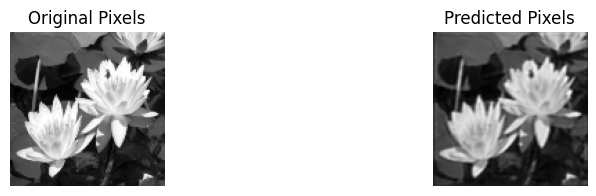

EVALUATION MODE || Epoch:    1/   5 | Loss: 0.0136
EVALUATION MODE || Epoch:    1/   5 | Mean Absolute Error: 0.0240
-------------------------------------------------------------------------
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:    1/ 128 | Loss: 0.0017
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:    2/ 128 | Loss: 0.0012
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:    3/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:    4/ 128 | Loss: 0.0019
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:    5/ 128 | Loss: 0.0016
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:    6/ 128 | Loss: 0.0022
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:    7/ 128 | Loss: 0.0017
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:    8/ 128 | Loss: 0.0016
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:    9/ 128 | Loss: 0.0018
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:   10/ 128 | Loss: 0.0016
TRAINING MODE 	|| Epoch:    2/   5 | Iteration:   11/ 128 | Loss: 0.0015
TRAINI

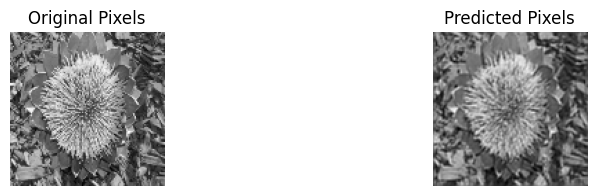

EVALUATION MODE || Epoch:    2/   5 | Loss: 0.0013
EVALUATION MODE || Epoch:    2/   5 | Mean Absolute Error: 0.0187
-------------------------------------------------------------------------
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:    1/ 128 | Loss: 0.0012
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:    2/ 128 | Loss: 0.0010
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:    3/ 128 | Loss: 0.0013
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:    4/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:    5/ 128 | Loss: 0.0010
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:    6/ 128 | Loss: 0.0010
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:    7/ 128 | Loss: 0.0010
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:    8/ 128 | Loss: 0.0012
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:    9/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:   10/ 128 | Loss: 0.0010
TRAINING MODE 	|| Epoch:    3/   5 | Iteration:   11/ 128 | Loss: 0.0014
TRAINI

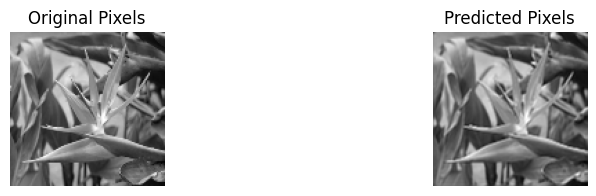

EVALUATION MODE || Epoch:    3/   5 | Loss: 0.0011
EVALUATION MODE || Epoch:    3/   5 | Mean Absolute Error: 0.0176
-------------------------------------------------------------------------
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:    1/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:    2/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:    3/ 128 | Loss: 0.0009
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:    4/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:    5/ 128 | Loss: 0.0008
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:    6/ 128 | Loss: 0.0009
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:    7/ 128 | Loss: 0.0009
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:    8/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:    9/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:   10/ 128 | Loss: 0.0009
TRAINING MODE 	|| Epoch:    4/   5 | Iteration:   11/ 128 | Loss: 0.0014
TRAINI

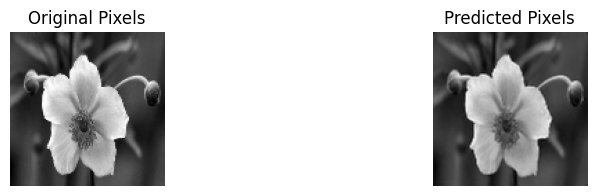

EVALUATION MODE || Epoch:    4/   5 | Loss: 0.0011
EVALUATION MODE || Epoch:    4/   5 | Mean Absolute Error: 0.0170
-------------------------------------------------------------------------
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:    1/ 128 | Loss: 0.0010
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:    2/ 128 | Loss: 0.0008
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:    3/ 128 | Loss: 0.0008
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:    4/ 128 | Loss: 0.0010
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:    5/ 128 | Loss: 0.0009
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:    6/ 128 | Loss: 0.0012
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:    7/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:    8/ 128 | Loss: 0.0011
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:    9/ 128 | Loss: 0.0009
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:   10/ 128 | Loss: 0.0007
TRAINING MODE 	|| Epoch:    5/   5 | Iteration:   11/ 128 | Loss: 0.0014
TRAINI

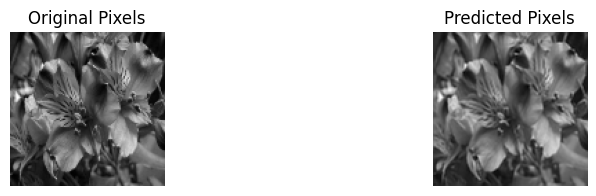

EVALUATION MODE || Epoch:    5/   5 | Loss: 0.0010
EVALUATION MODE || Epoch:    5/   5 | Mean Absolute Error: 0.0168
-------------------------------------------------------------------------


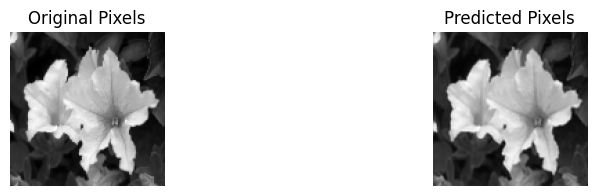

Model saved at ./models/model.pth


In [19]:
def train_and_test():
    model = CNN()
    model.to(DEVICE)

    losses, maes = train_model(model, train_valid_loader, test_loader)
    mae = test_model(model, test_loader)

    if os.path.exists("./models") == False:
        os.mkdir("./models")
    torch.save(model.state_dict(), "./models/model.pth")
    print(f"Model saved at ./models/model.pth")

train_and_test()